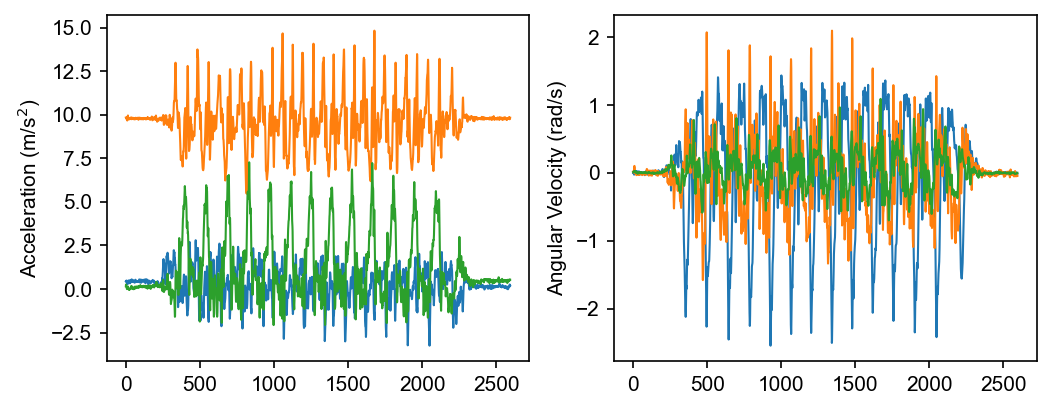

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'

from orientation import *
from signal_processing import *

fs = 100

acc = pd.read_csv('./data/Accelerometer_Walking_1.2m.csv').iloc[1000:-300, 1:].to_numpy()
gyr = pd.read_csv('./data/Gyroscope_Walking_1.2m.csv').iloc[1000:-300, 1:].to_numpy()

_, ax = plt.subplots(1, 2, figsize=(8,3), dpi=150)
ax[0].plot(acc, lw=1)
ax[1].plot(gyr, lw=1)
ax[0].set_ylabel('Acceleration (m/s$^2$)')
ax[1].set_ylabel('Angular Velocity (rad/s)')
plt.show()

In [ ]:
from scipy.signal import find_peaks
from ahrs.filters import Madgwick
from ahrs.common import DCM
from scipy.integrate import cumtrapz

w_bias = np.mean(gyr[:100], axis=0)
w = gyr - w_bias
g_sensor = np.mean(acc[:100, :], axis=0)
g_global = detect_ideal_gravity(g_sensor)
R = rodrigues_rotation(g_sensor, g_global)

# Measures aligned with gravity
w_m = (R @ w.T).T 
a_m = (R @ acc.T).T
w_m = w_m[:-2, :] # adjust dimensions

# Detection of gait events #
w_ml = bwfilt(-w_m[:, 0], 4, 5, fs)
pks, _ = find_peaks(w_ml, height=np.quantile(w_ml, q=.85), distance=int(0.5*fs))

ge = []
for p in pks:
    for k in range(p, 1, -1):
        if w_m[k, 0] * w_m[k-1, 0] < 0:
            ge.append(k-2)
            break     

# Create breaks (strides)
breaks = []
for i in range(0, len(ge)-1):
    breaks.append((ge[i], ge[i+1]-1))

#a_m, w_m = bwfilt(a_m, 4, 5, fs), bwfilt(w_m, 4, 5, fs)

# Estimate here
sl = []
for i, (ti, tf) in enumerate(breaks):
    a_m_stride, w_m_stride = a_m[ti:tf, :], w_m[ti:tf, :]
    #a_I = get_linear_acceleration(a_m=a_m_stride, w_m=w_m_stride, fs=fs, g_global=g_global, convert_to_mss=False)
    # Compute overall orientation over time
    mad = Madgwick(gyr=w_m_stride, acc=a_m_stride, frequency=fs, q0=np.array([1, 0, 0, 0]))
    q = mad.Q # Orientation quaternion

    # Initialize acceleration of the inertial frame
    a_I = np.zeros_like(a_m_stride)
    
    for k in range(q.shape[0]):
        R_IB = DCM()
        R_IB = R_IB.from_quaternion(q=q[k])
        a_I[k] = (R_IB @ a_m_stride[k]) 

    a_I -= a_I[0]

    # _, ax = plt.subplots(2, 2, figsize=(10,6), dpi=150)
    # ax[0,0].plot(w_m_stride)
    # ax[0,1].plot(a_I)

    v_AP = integrate_ndim(a_I[:, 2], fs=fs)
    d_AP = integrate_ndim(v_AP, fs=fs)

    sl.append(np.abs(max(d_AP, key=abs)))

    # ax[1,0].plot(v_AP)
    # ax[1,1].plot(d_AP)
    # plt.show()
plt.plot(np.arange(1,len(sl)+1), sl, lw=1, ls='--', marker='o')
plt.title(f'Total Distance: {np.sum(sl):.1f} m (mean SL: {np.mean(sl):.1f} m)')
plt.show()

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2596 is different from 3)

In [116]:
breaks

[(328, 476),
 (477, 621),
 (622, 764),
 (765, 910),
 (911, 1050),
 (1051, 1181),
 (1182, 1326),
 (1327, 1460),
 (1461, 1599),
 (1600, 1735),
 (1736, 1886),
 (1887, 2027),
 (2028, 2193)]

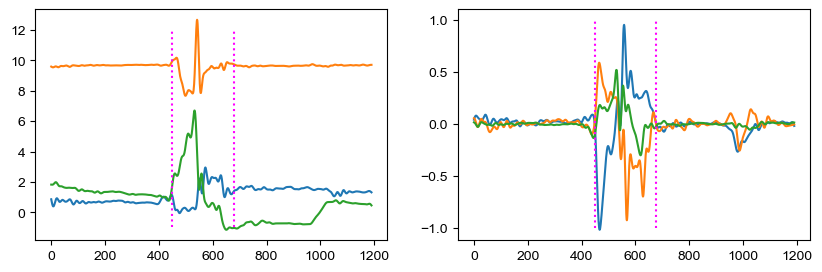

In [132]:
acc_ss = pd.read_csv('./data/Accelerometer_Single_Step.csv').iloc[:, 1:].to_numpy()
gyr_ss = pd.read_csv('./data/Gyroscope_Single_Step.csv').iloc[:, 1:].to_numpy()

a_ss, w_ss = bwfilt(acc_ss, 4, 5, fs), bwfilt(gyr_ss, 4, 5, fs)


_, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(a_ss)
ax[1].plot(w_ss)

pks = [np.argmin(w_ss[:, 0]), np.argmax(w_ss[:, 0])]

for k in range(pks[0], 1, -1):
    if w_ss[k, 0] * w_ss[k-1, 0] < 0:
        ti = k-1
        break

for k in range(pks[1], len(w_ss)-1):
    if w_ss[k, 0] * w_ss[k+1, 0] < 0:
        tf = k+1
        break

ax[0].vlines([ti, tf], ymin=-1, ymax=12, colors='magenta', ls=':')
ax[1].vlines([ti, tf], ymin=-1, ymax=1, colors='magenta', ls=':')
plt.show()

a_m_stride, w_m_stride = bwfilt(a_ss[ti:tf, :], 4, 5, fs), bwfilt(w_ss[ti:tf, :], 4, 5, fs)



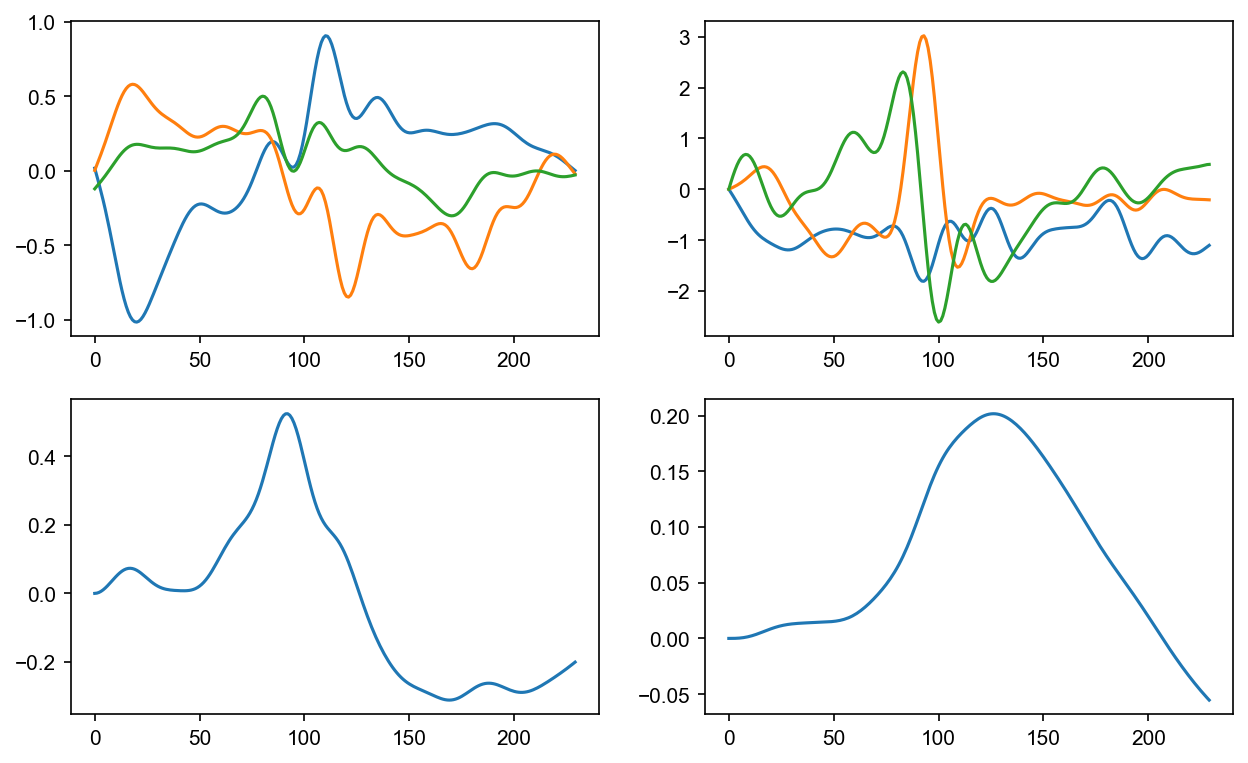

In [133]:
mad = Madgwick(gyr=w_m_stride, acc=a_m_stride, frequency=fs, q0=np.array([1, 0, 0, 0]))
q = mad.Q # Orientation quaternion

# Initialize acceleration of the inertial frame
a_I = np.zeros_like(a_m_stride)

for k in range(q.shape[0]):
    R_IB = DCM()
    R_IB = R_IB.from_quaternion(q=q[k])
    a_I[k] = (R_IB @ a_m_stride[k]) 

a_I -= a_I[0]

_, ax = plt.subplots(2, 2, figsize=(10,6), dpi=150)
ax[0,0].plot(w_m_stride)
ax[0,1].plot(a_I)

v_AP = integrate_ndim(a_I[:, 2], fs=fs)
d_AP = integrate_ndim(v_AP, fs=fs)

ax[1,0].plot(v_AP)
ax[1,1].plot(d_AP)

In [120]:
np.min(v_AP) * len(v_AP) / 100

-2.230057648659131